# railファイル確認用

In [10]:
import boto3
import os
import shelve
import copy
import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import pandas as pd
# import src.utilsST_01 as utlst
import src.helpers as helpers
import src.visualize as vis
from src.config import appProperties
from src.trolley import trolley
from src.similar_pixel import pixel

config = appProperties('config.yml')

In [11]:
dir_area = "Chuo_01_Tokyo-St_up_20230201_knight"
camera_num = "HD11"
target_dir = config.image_dir + "/" + dir_area + "/" + camera_num
outpath = config.output_dir + "/" + dir_area + "/" + camera_num

base_images = helpers.list_images(target_dir)

rail = shelve.open(outpath + "/rail.shelve")

In [3]:
keys = rail.keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: name
1: HD11


In [4]:
keys = rail[camera_num].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
1: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
2: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
3: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
4: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg
5: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022317.jpg
6: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022318.jpg
7: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022319.jpg
8: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022320.jpg
9: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022321.jpg
10: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022322.jpg
11: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022323.jpg
12: imgs/Chuo_01_Tokyo-St_up_20230201_

In [5]:
image_path = base_images[0]
image_path

'imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg'

In [6]:
keys = rail[camera_num][image_path].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: trolley1
1: trolley2
2: trolley3


In [7]:
keys = rail[camera_num][image_path]["trolley1"].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: trolley_id
1: isInFrame
2: ix
3: estimated_upper_edge
4: estimated_lower_edge
5: estimated_width
6: estimated_slope
7: blightness_center
8: blightness_mean
9: blightness_std
10: y_init_u
11: y_init_l
12: num_obs
13: missingCounts
14: initial_state_covariance
15: initial_state_mean
16: transition_matrix
17: transition_covariance
18: kf_multi
19: current_state
20: last_state
21: last_state_covariance
22: estimated_upper_edge_variance
23: estimated_lower_edge_variance
24: estimated_slope_variance
25: measured_upper_edge
26: measured_lower_edge
27: missing_state
28: trolley_end_reason
29: brightness
30: new_measurement
31: mask
32: center
33: last_boundary_expectation
34: last_brightness
35: mxn_slope_iy
36: value_iy
37: box_width
38: search_list
39: upper_line
40: lower_line
41: upper_diff
42: lower_diff
43: w_ear
44: as_aj
45: upper_boundary
46: lower_boundary
47: avg_brightness
48: sigmoid_edge_u
49: sigmoid_edge_l
50: last_upper_line
51: last_lower_line
52: edge_std_list_u
53: edge_

In [10]:
image_path = base_images[1]
rail["HD11"][image_path]["trolley1"]["estimated_upper_edge"]

[1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,

imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg


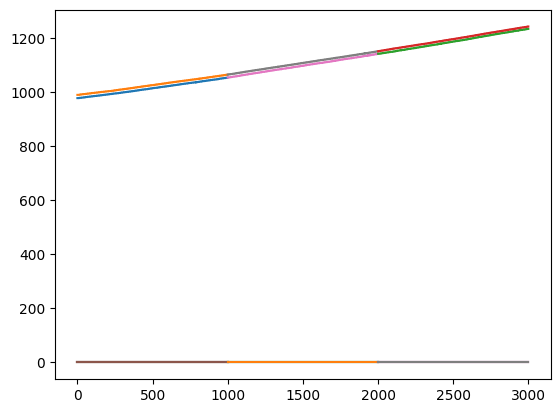

In [13]:
img_num = 3
for idx in range(img_num):
    image_path = base_images[idx]
    print(image_path)
    for trolley_id in config.trolley_ids:
        x = [n + 1000 * idx for n in rail[camera_num][image_path][trolley_id]["ix"]]
        plt.plot(x, rail[camera_num][image_path][trolley_id]["estimated_upper_edge"])
        plt.plot(x, rail[camera_num][image_path][trolley_id]["estimated_lower_edge"])
plt.show()

In [14]:
rail.close()